In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import random
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet

# Download the WordNet corpus
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielskahill/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielskahill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
max_length = 100
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 32

In [4]:
df = pd.read_csv("..//efcamdat_sub.csv")

In [5]:
df['labels'] = df['cefr_numeric'].apply(lambda x: x-1)

In [6]:
text = df['text']
labels = df['labels']

In [7]:
df[df['labels'] == 5] = 4

In [8]:
train_df, test_df = train_test_split(df, test_size=.1, shuffle=True)

In [9]:
len(train_df)

340170

In [10]:
valid_df = train_df.iloc[:34000].copy()
train_df = train_df.iloc[34000:]
test_df = test_df.iloc[:1000]

In [11]:
def clip_words(text, num_words=5):
    text = str(text)
    words = text.split()
    if len(words) > 2 * num_words:
        return ' '.join(words[num_words:-num_words])
    else:
        # If the text has fewer than 2 * num_words, return an empty string or handle accordingly
        return text

In [12]:
train_df['text_clipped'] = train_df['text'].apply(clip_words)

In [13]:
train_df['text_clipped'] = train_df['text_clipped'].apply(lambda x: str(x))

In [14]:
def synonym_replacement(text):
    words = text.split()
    new_words = []
    
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym if synonym != word else word)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)

def random_insertion(text):
    words = text.split()
    new_words = words.copy()
    synonyms = [wordnet.synsets(word)[0].lemmas()[0].name() for word in words if wordnet.synsets(word)]
    
    num_insertions = random.randint(1, 3)
    for _ in range(num_insertions):
        insert_word = random.choice(synonyms) if synonyms else random.choice(words)
        position = random.randint(0, len(new_words))
        new_words.insert(position, insert_word)
    
    return ' '.join(new_words)

def random_deletion(text, p=0.2):
    words = text.split()
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else words[0]

def sentence_shuffling(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return text
    random.shuffle(sentences)
    return ' '.join(sentences)

def augment(text):
    if random.random() > .3:
        return text
    else:
        if random.random() < .2:
            text = synonym_replacement(text)
        if random.random() < .2: 
            text = random_insertion(text)
        if random.random() < .2:
            text = random_deletion(text, p=0.2)
        if random.random() < .2: 
            text = sentence_shuffling(text)
        return text 


In [15]:
tqdm.pandas()
train_df['text_clipped'] = train_df['text_clipped'].progress_apply(lambda x: augment(x))

100%|███████████████████████████████████| 306170/306170 [00:30<00:00, 9976.18it/s]


## BERT

In [16]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

#tokenize text data for each split
train_encodings = bert_tokenizer(train_df["text_clipped"].tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
valid_encodings = bert_tokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'token_type_ids': encodings['token_type_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return dataset

#create TF datasest with encoding and labels
train_dataset = create_dataset(train_encodings, train_df['labels'])
valid_dataset = create_dataset(valid_encodings, valid_df['labels'])
test_dataset = create_dataset(test_encodings, test_df['labels'])

#batching
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Metal device set to: Apple M1 Pro


2024-07-20 17:47:35.461008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-20 17:47:35.462213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g.

In [17]:
def create_bert_classification_model(bert_model, num_classes=6, num_train_layers=0, hidden_size=200, dropout=0.5, learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - i) for i in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    bert_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

In [18]:
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [19]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [20]:
bert_classification_model_history = bert_classification_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1,
)

2024-07-20 17:52:31.959327: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-20 17:52:31.965817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  34/9568 [..............................] - ETA: 2:51:27 - loss: 1.5095 - accuracy: 0.3980

KeyboardInterrupt: 

## RoBERTa

In [20]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

train_encodings = rtokenizer(train_df["text_clipped"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_df['labels']))
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_df['labels']))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [21]:
def create_roberta_cl_model(model,
                         num_classes = 5,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)
    # dense = tf.keras.layers.Dense(256, activation='relu')(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [22]:
roberta_cl_model = create_roberta_cl_model(model=roberta_model, num_classes=6)

In [23]:
roberta_cl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                         

In [24]:
roberta_cl_model_history = roberta_cl_model.fit(train_dataset,
                                      validation_data=valid_dataset,
                                      epochs=3)

Epoch 1/3


2024-07-20 17:32:06.381578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 17:32:11.567217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 17:32:12.017125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


594/594 [==============================] - ETA: 0s - loss: 0.8560 - accuracy: 0.6623

2024-07-20 17:36:05.023570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 17:36:09.398792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


594/594 [==============================] - 267s 433ms/step - loss: 0.8560 - accuracy: 0.6623 - val_loss: 0.6732 - val_accuracy: 0.7670
Epoch 2/3
594/594 [==============================] - 231s 388ms/step - loss: 0.5913 - accuracy: 0.7822 - val_loss: 0.5765 - val_accuracy: 0.8000
Epoch 3/3
594/594 [==============================] - 234s 392ms/step - loss: 0.4979 - accuracy: 0.8226 - val_loss: 0.5220 - val_accuracy: 0.8220


In [26]:
test_encodings = rtokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_df['labels']))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
preds = roberta_cl_model.predict(tdataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

2024-07-20 17:44:41.648801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 17:44:47.426321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 27s 632ms/step
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       261
           1       0.87      0.83      0.85       264
           2       0.81      0.83      0.82       256
           3       0.78      0.80      0.79       171
           4       0.61      0.65      0.63        48

    accuracy                           0.84      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.84      0.84      0.84      1000



In [28]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

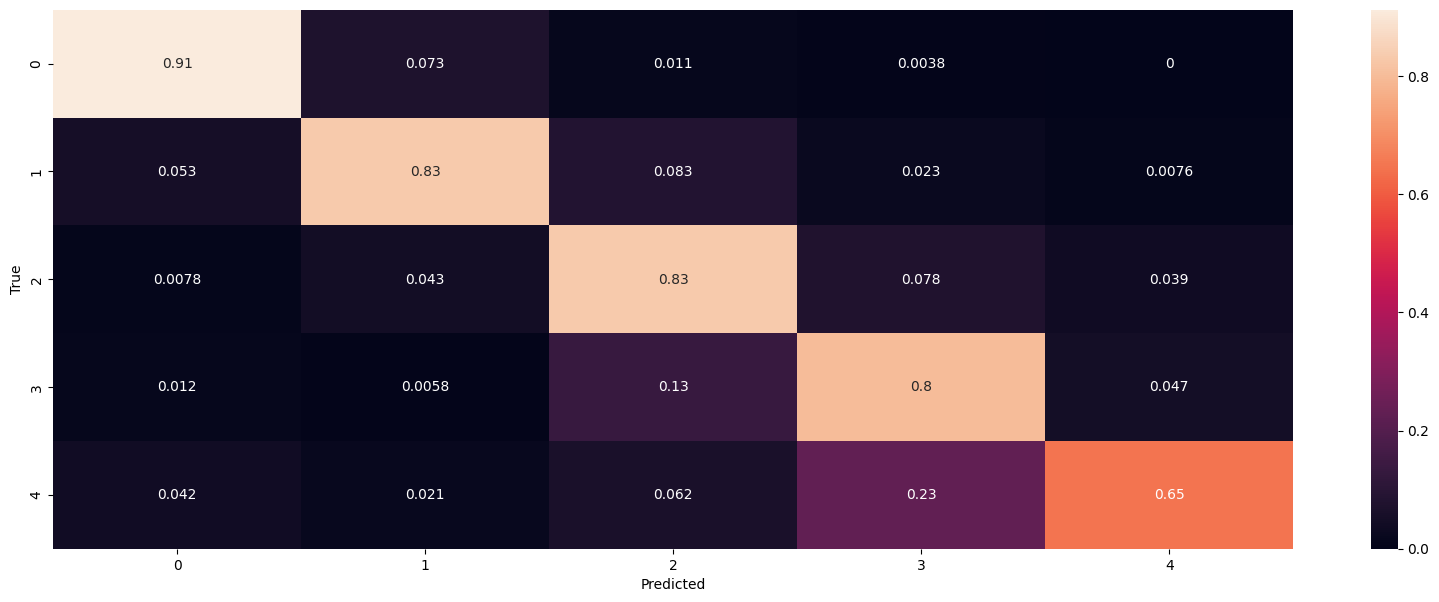

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")